# TO DO List
1. Get the 'Average customer ratings' for comfort, cleanliness, location, quality
1. Do a scatter plot of distance from sydney vs bookings count???
1. Distance vs revenue?
1. Distance vs revenue per person (assuming full occupancy)
1. Percentage occupancy for the month vs distance
1. 30/60/90 day occupancy vs distance (forward bookings)
1. Last 30/60/90 day actual occupance vs distance (history bookings)
1. Count how many places have zero bookings

In [3]:
import sysconfig
import os
import numpy as np
import pandas as pd
import json
import distutils
import datetime
import scrapy
import requests
import json
import logging
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
import csv

from IPython.core.display import display, HTML

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

import ipywidgets as widgets

%matplotlib inline

In [22]:
date_str = datetime.datetime.now().strftime("%Y-%m-%d")

#date_str = '2018-06-18'

print("Date: " + date_str)

Date: 2018-06-22


## Dataset 1 - nsw_extract
Load the nsw_extract daily file. This starts with the https://www.stayz.com.au/accommodation/nsw page and then follows the link to each propert. This is the quick (30 minutes) extract of raw details, as it excludes the calendar details.

In [23]:
# Read the data file and display
nsw_extract_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/stayz_nsw_extract_' + date_str + '.json')

# Reindex for 'property_id'
nsw_extract_2 = nsw_extract_1.set_index('property_id')

nsw_extract_3 = nsw_extract_2.sort_index()

nsw_extract = nsw_extract_3


print("nsw_extract index: " + str(nsw_extract.index.dtype_str))

nsw_extract.head()

nsw_extract index: int64


bathrooms  bedrooms  beds  \
property_id                              
4840533              1         3     3   
4841630              1         2     2   
4845880              4         4     6   
4848261              1         1     1   
4887073              1         3     3   

                                              description_full  \
property_id                                                      
4840533      [JUST LISTED The lovely old cottage has been f...   
4841630      [This 2 bedroom unit is only 2 blocks to the C...   
4845880      [Just a few steps from the historic and beauti...   
4848261      [Nestled away at the end of a quiet cul-de-sac...   
4887073      [---ALL OUR YOURSTAY GROUP PROPERTIES CAN BE B...   

             description_wc  guests  \
property_id                           
4840533                  70       6   
4841630                  57       4   
4845880                 192       8   
4848261                 148       2   
4887073                 247       6   

                                                       heading  init_price  \
property_id                                                                  
4840533                          Quiet street and close to CBD         133   
4841630                                   Perfect Parker Place         253   
4845880      Central to Orange, PLC, Duntryleague, a comfor...         290   
4848261                             Beautiful Claremont Studio         135   
4887073                Yourstay Group The Edward Townhouse 151         192   

                   lat        lng property_type  reviews         scraped_date  \
property_id                                                                     
4840533     -33.284756  149.08614         House        2  2018-06-22 22:19:21   
4841630     -33.279133  149.10138     Townhouse        0  2018-06-22 22:19:17   
4845880     -33.279736  149.08318         House        0  2018-06-22 22:19:16   
4848261     -33.288708  149.06300        Studio        5  2018-06-22 22:19:17   
4887073     -33.288044  149.10577         House        2  2018-06-22 22:19:16   

            syd_brg  syd_brg_deg  syd_dist_km  \
property_id                                     
4840533           W          291          209   
4841630           W          291          208   
4845880           W          291          209   
4848261           W          291          210   
4887073           W          291          207   

                                                           url  
property_id                                                     
4840533      https://www.stayz.com.au//accommodation/nsw/ex...  
4841630      https://www.stayz.com.au//accommodation/nsw/ex...  
4845880      https://www.stayz.com.au//accommodation/nsw/ex...  
4848261      https://www.stayz.com.au//accommodation/nsw/ex...  
4887073      https://www.stayz.com.au//accommodation/nsw/ex...

## Dataset 2 - Geocode Addresses
Load the full geocoded address file. This is the Google reverse geocoder API output for each of the latitude/longitude details for each property. Note that the street number is not exact for the property but is within a few houses and is the same street. Stayz deliberatly obfuscates the exact location however all other details are correct apart from house number.

In [4]:
# Read the data file and display
geodata_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_geocoded/stayz_geocoded_full.json')

geodata_2 = geodata_1.set_index('property_id')
geodata_3 = geodata_2.sort_index()

geodata = geodata_3


print("geodata index: " + str(geodata.index.dtype_str))

geodata.head(10)

geodata index: int64


council  \
property_id                   
52                  Gosford   
717               Pittwater   
806             Great Lakes   
1036                Gosford   
1266             Shoalhaven   
1873             Shoalhaven   
1971            Great Lakes   
1971            Great Lakes   
2040             Shoalhaven   
2042         Blue Mountains   

                                             formatted_address postcode  \
property_id                                                               
52                24 Avoca Dr, Avoca Beach NSW 2251, Australia     2251   
717          342 Whale Beach Rd, Palm Beach NSW 2108, Austr...     2108   
806           5 Coast Ave, Boomerang Beach NSW 2428, Australia     2428   
1036             15 Ficus Ave, Avoca Beach NSW 2251, Australia     2251   
1266            42 Elizabeth Dr, Vincentia NSW 2540, Australia     2540   
1873           182 Elizabeth Dr, Vincentia NSW 2540, Australia     2540   
1971           30 Ski Cove St, Smiths Lake NSW 2428, Australia     2428   
1971           30 Ski Cove St, Smiths Lake NSW 2428, Australia     2428   
2040         6 Bellbird Cl, Mollymook Beach NSW 2539, Austr...     2539   
2042         119 Evans Lookout Rd, Blackheath NSW 2785, Aus...     2785   

                      st_name st_nbr state           suburb  
property_id                                                  
52                   Avoca Dr     24   NSW      Avoca Beach  
717            Whale Beach Rd    342   NSW       Palm Beach  
806                 Coast Ave      5   NSW  Boomerang Beach  
1036                Ficus Ave     15   NSW      Avoca Beach  
1266             Elizabeth Dr     42   NSW        Vincentia  
1873             Elizabeth Dr    182   NSW        Vincentia  
1971              Ski Cove St     30   NSW      Smiths Lake  
1971              Ski Cove St     30   NSW      Smiths Lake  
2040              Bellbird Cl      6   NSW  Mollymook Beach  
2042         Evans Lookout Rd    119   NSW       Blackheath

## Dataset 3 - Bookings data
This is extracted from the raw data in the nsw_calendar extracts, and each booking details are calculated including arrival date, and number of nights booked. We can aggregate this for each property.

This is extracted from Postgres database based on the last successful extract of a property for the month. This means that only bookings which are actually occur are in the calendar.

In [5]:
# Read the bookings file
bk_date_str = date_str

#book_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_bookings/stayz_bookings_' + bk_date_str + '.json',convert_dates=['arr_dt','dep_dt'])
# Read the CSV file generated from Postgres. This has the corrected date splits over the month
# It ignores bookings more than 7 days in length
# It also has all the months from Feb 2018 until May 2018
book_1 = pd.read_csv('/Users/taj/GitHub/scraping/stayz_analysis/orange_large_month_summary.csv')

book_1.head()
# Change the index to property id
book_2 = book_1.set_index('property_id')

# Sort the dataset so that all property id bookings are together
book_3 = book_2.sort_index()


# If the booking is greater than 7 days then may not be a customer
# If the booking is greater than 14 days then assume it is blocked out and not a booking
book_3['book_type'] = book_3['book_days'].map(lambda x: 'Host' if x > 14 else 'Cust')

book_cust_1 = book_3[book_3['book_type'] == 'Cust']

# Get the dates which are after the date_str

#-------------- data in csv is now the history data, split correctly by mth value


# Only take the next 30 days and see how many bookings there are in total
#date_1 = datetime.datetime.strptime(date_str, "%Y-%m-%d")

#date_30 = date_1 + datetime.timedelta(days=29)

# This gives 30 days inclusive of the start date
#print(date_30.strftime('29 Days time is %d, %b %Y'))

#book_cust_2 = book_cust_1[book_cust_1['arr_dt'] >= date_1]
#book_cust_3 = book_cust_2[book_cust_2['arr_dt'] <= date_30]

book_cust_1.head()

book_cust_2 = book_cust_1[book_cust_1['mth'] == 5]

book_cust = book_cust_2

book_cust.head()

mth  book_days  book_count book_type
property_id                                      
1873           5          2           1      Cust
1971           5          3           1      Cust
2107           5          2           1      Cust
4121           5          3           1      Cust
4598           5          2           1      Cust

In [6]:
a = book_cust.loc[1873]

a

mth              5
book_days        2
book_count       1
book_type     Cust
Name: 1873, dtype: object

In [7]:
# Check a specific property_id to make sure the individual bookings are calculated correctly
a = book_cust.loc[8131]

a
#a.sort_values(by=['arr_dt'])

mth              5
book_days       10
book_count       3
book_type     Cust
Name: 8131, dtype: object

## Dataset 4 - Calendar


In [24]:
# Read the Calendar extract to get additional details
cal_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_calendar/stayz_calendar_' + date_str + '.json')

# Change values of -1.0 into NaN for stats analysis
cal_1.loc[cal_1['review_count'] == -1.0, 'review_count'] = np.nan
cal_1.loc[cal_1['review_value'] == -1.0, 'review_value'] = np.nan

#cal_2 = cal_1.drop(['calendar'], axis=1)

cal_3 = cal_2 #[(cal_2['property_id'] != 0) & (cal_2['property_id'] != '')]

cal_4 = cal_3

cal_4['property_id'] = cal_4['property_id'].astype(np.int64)

cal_5 = cal_4.set_index(['property_id'])

cal_6 = cal_5.sort_index()

cal = cal_6

cal.head()


ext_at  \
property_id                       
4840533     2018-06-22 22:24:22   
4841630     2018-06-22 22:23:42   
4845880     2018-06-22 22:23:31   
4848261     2018-06-22 22:23:48   
4887073     2018-06-22 22:23:35   

                                                      features  photos  \
property_id                                                              
4840533      Dining\nDishes and utensils\nDVD player\nHair ...      14   
4841630                                                             11   
4845880      Air conditioning\nBalcony\nBooks\nChild's high...      22   
4848261      Air conditioning\nBooks\nClothes dryer\nCoffee...       8   
4887073      Air conditioning\nDeck/Patio\nDining\nDishes a...      24   

             review_count  review_value  
property_id                              
4840533               2.0           5.0  
4841630               NaN           NaN  
4845880               NaN           NaN  
4848261               5.0           4.8  
4887073               2.0           4.5

## Generate a HTML page to cross check the calendar

1. Copy the 'calendar' text into a file, ie 9175890.html
1. Concatenate the start and end HTML files `cat calendar_start.html 9175890.html calendar_end.html > 9175890_full.html`
1. Open the resulting html in browser to cross check the details

In [66]:
cal_start_html = """
<!DOCTYPE html>
<!-- saved from url=(0074)https://www.stayz.com.au/accommodation/nsw/explorer-country/orange/9170214 -->
<html class=" js no-touch svg object-fit" vocab="http://schema.org/" style="">
   <head>
      <meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
      <style type="text/css">.gm-style .gm-style-mtc label,.gm-style .gm-style-mtc div{font-weight:400}</style>
      <link type="text/css" rel="stylesheet" href="./StayzHTML_files/css">
      <style type="text/css">.gm-style .gm-style-cc span,.gm-style .gm-style-cc a,.gm-style .gm-style-mtc div{font-size:10px}</style>
      <style type="text/css">@media print {  .gm-style .gmnoprint, .gmnoprint {    display:none  }}@media screen {  .gm-style .gmnoscreen, .gmnoscreen {    display:none  }}</style>
      <style type="text/css">.gm-style-pbc{transition:opacity ease-in-out;background-color:rgba(0,0,0,0.45);text-align:center}.gm-style-pbt{font-size:22px;color:white;font-family:Roboto,Arial,sans-serif;position:relative;margin:0;top:50%;-webkit-transform:translateY(-50%);-ms-transform:translateY(-50%);transform:translateY(-50%)}</style>
      <style type="text/css">@charset "UTF-8";[ng\:cloak],[ng-cloak],[data-ng-cloak],[x-ng-cloak],.ng-cloak,.x-ng-cloak,.ng-hide:not(.ng-hide-animate){display:none !important;}ng\:form{display:block;}.ng-animate-shim{visibility:hidden;}.ng-anchor{position:absolute;}</style>
      <script src="./StayzHTML_files/f.txt"></script><script src="./StayzHTML_files/pubads_impl_rendering_219.js"></script><script type="text/javascript" src="./StayzHTML_files/9ac4307446"></script><script src="./StayzHTML_files/nr-1071.min.js"></script><script type="text/javascript" async="" src="./StayzHTML_files/bv-analytics.js"></script><script async="" src="./StayzHTML_files/fbevents.js"></script><script type="text/javascript" async="" src="./StayzHTML_files/8eaf869a2e2a957dd8055da1279e8736.js"></script><script src="./StayzHTML_files/serverComponent.php"></script>
      <!-- START /core : meta-environment -->
      <meta http-equiv="x-ua-compatible" content="ie=edge">
      <meta name="viewport" content="width=device-width, initial-scale=1, minimum-scale=1, maximum-scale=2, user-scalable=yes">
      <!-- END   /core : meta-environment -->
      <!-- START /core : scripts-head-top -->
      <!-- START /core : scripts-head-top-site -->
      <!-- START /core : modernizr -->
      <script async="" type="text/javascript" src="./StayzHTML_files/Bootstrap.js"></script><script type="text/javascript" async="" src="./StayzHTML_files/linkid.js"></script><script src="./StayzHTML_files/4387.js" async="" type="text/javascript"></script><script src="./StayzHTML_files/bat.js" async=""></script><script id="edap-ua" async="" type="text/javascript" src="./StayzHTML_files/analytics.js"></script><script src="./StayzHTML_files/modernizr.bbcd1abc.js"></script>
      <script src="./StayzHTML_files/stab-analytics-polyfill.307be527.js"></script>
      <!-- END   /core : modernizr -->
      <!-- END   /core : scripts-head-top-site -->
      <!-- END   /core : scripts-head-top -->
      <!-- START /core : meta-content -->
      <title>Lovely "Orangewood" Home, a Orange Farmstay | Stayz</title>
      <meta name="google-site-verification" content="pbK60qhnJQEH6RDaESxevTmETbUGilMzBWrddLT2oek">
      <meta name="keywords" content="holiday rentals, holiday accommodation, holiday homes, holiday houses, holiday apartments">
      <meta name="description" content="Book Explorer Country accommodation with Stayz, home to over 40,000 holiday houses Australia-wide.">
      <!-- END   /core : meta-content -->
      <!-- START /core : meta-links -->
      <meta name="referrer" content="unsafe-url">
      <link href="https://www.stayz.com.au/accommodation/nsw/explorer-country/orange/9170214" rel="canonical">
      <!-- END   /core : meta-links -->
      <!-- START /core : styles-head -->
      <!-- START /core : styles-head-site -->
      <link href="./StayzHTML_files/css(1)" rel="stylesheet">
      <link href="./StayzHTML_files/application.96453680.css" rel="stylesheet">
      <!-- END   /core : styles-head-site -->
      <!-- END   /core : styles-head -->
      <!-- START /core : scripts-head-bottom -->
      <!-- START /core : scripts-head-bottom-site -->
      <!-- START /core : edap-adl -->
      <script type="text/javascript">
         function getCookie(cname) {
             var name = cname + "=";
             var ca = document.cookie.split(';');
             for(var i = 0; i < ca.length; i++) {
                 var c = ca[i];
                 while (c.charAt(0) == ' ') {
                     c = c.substring(1);
                 }
                 if (c.indexOf(name) == 0) {
                     return c.substring(name.length, c.length);
                 }
             }
             return "";
         }
         
         window.analyticsdatalayer = {"monikerbrand":"stayz","appname":"stayz-consumer","appenvironment":"production","appversion":"0.227.1","pagetype":"property","pageflow":"-1","pagename":"property","visitortype":"traveler","sensitive":"false","mpaasregion":"-1","geonode":"Australia:NSW:Explorer Country:Orange","listingid":"9170214","testattributes":"-1","onlinepayments":"true","item2":"2","item3":"4","item4":"4"}||{};
         window.analyticsdatalayer.sessionid = getCookie("has");
         window.analyticsdatalayer.visitorid = getCookie("hav");
         window.edapOptions = window.edapOptions||{};
         
         // Required so that we can push functions to be processed once EDAP async-loading is complete
         window.edap = window.edap || [];
         
         window.edapOptions.skipFeatureFlags=false;
      </script>
      <script src="./StayzHTML_files/edap-integrations.5a2a096a.js"></script>
      <!-- END   /core : edap-adl -->
      <!-- END   /core : scripts-head-bottom-site -->
      <!-- START /core : crazy-egg -->
      <script type="text/javascript">
         var CE_SNAPSHOT_NAME = "property rsp0 desktop";
         setTimeout(function(){var a=document.createElement('script');
             var b=document.getElementsByTagName('script')[0];
             a.src=document.location.protocol+'//script.crazyegg.com/pages/scripts/0013/4387.js?'+Math.floor(new Date().getTime()/3600000);
             a.async=true;a.type='text/javascript';b.parentNode.insertBefore(a,b);}, 1);
      </script>
      <!-- END   /core : crazy-egg -->
      <!-- START /core : hot-jar -->
      <script type="text/javascript">
         (function(h,o,t,j,a,r){h.hj=h.hj||function(){(h.hj.q=h.hj.q||[]).push(arguments)};h._hjSettings={hjid:316893,hjsv:5};a=o.getElementsByTagName('head')[0];r=o.createElement('script');r.async=1;r.src=t+h._hjSettings.hjid+j+h._hjSettings.hjsv;a.appendChild(r)})(window,document,'//static.hotjar.com/c/hotjar-','.js?sv=');
      </script><script async="" src="./StayzHTML_files/hotjar-316893.js"></script>
      <!-- END   /core : hot-jar -->
      <script>(function (w, d, t, r, u) {
         var f, n, i;
         w[u] = w[u] || [], f = function () {
             var o =
                 {ti: "5152476"}
                 ;
             o.q = w[u], w[u] = new UET(o), w[u].push("pageLoad")
         }, n = d.createElement(t), n.src = r, n.async = 1, n.onload = n.onreadystatechange = function () {
             var s = this.readyState;
             s && s !== "loaded" && s !== "complete" || (f(), n.onload = n.onreadystatechange = null)
         }
             , i = d.getElementsByTagName(t)[0], i.parentNode.insertBefore(n, i)
         })(window, document, "script", "//bat.bing.com/bat.js", "uetq");
      </script>
      <noscript>
         <img src="https://bat.bing.com/action/0?ti=5152476&Ver=2" height="0" width="0" style="display:none; visibility: hidden;"/>
      </noscript>
      <!-- END   /core : scripts-head-bottom -->
      <script type="text/javascript">(window.NREUM||(NREUM={})).loader_config={xpid:"VQcGUV9XDhABUFdRAgYAUg=="};window.NREUM||(NREUM={}),__nr_require=function(t,n,e){function r(e){if(!n[e]){var o=n[e]={exports:{}};t[e][0].call(o.exports,function(n){var o=t[e][1][n];return r(o||n)},o,o.exports)}return n[e].exports}if("function"==typeof __nr_require)return __nr_require;for(var o=0;o<e.length;o++)r(e[o]);return r}({1:[function(t,n,e){function r(t){try{s.console&&console.log(t)}catch(n){}}var o,i=t("ee"),a=t(15),s={};try{o=localStorage.getItem("__nr_flags").split(","),console&&"function"==typeof console.log&&(s.console=!0,o.indexOf("dev")!==-1&&(s.dev=!0),o.indexOf("nr_dev")!==-1&&(s.nrDev=!0))}catch(c){}s.nrDev&&i.on("internal-error",function(t){r(t.stack)}),s.dev&&i.on("fn-err",function(t,n,e){r(e.stack)}),s.dev&&(r("NR AGENT IN DEVELOPMENT MODE"),r("flags: "+a(s,function(t,n){return t}).join(", ")))},{}],2:[function(t,n,e){function r(t,n,e,r,s){try{p?p-=1:o(s||new UncaughtException(t,n,e),!0)}catch(f){try{i("ierr",[f,c.now(),!0])}catch(d){}}return"function"==typeof u&&u.apply(this,a(arguments))}function UncaughtException(t,n,e){this.message=t||"Uncaught error with no additional information",this.sourceURL=n,this.line=e}function o(t,n){var e=n?null:c.now();i("err",[t,e])}var i=t("handle"),a=t(16),s=t("ee"),c=t("loader"),f=t("gos"),u=window.onerror,d=!1,l="nr@seenError",p=0;c.features.err=!0,t(1),window.onerror=r;try{throw new Error}catch(h){"stack"in h&&(t(8),t(7),"addEventListener"in window&&t(5),c.xhrWrappable&&t(9),d=!0)}s.on("fn-start",function(t,n,e){d&&(p+=1)}),s.on("fn-err",function(t,n,e){d&&!e[l]&&(f(e,l,function(){return!0}),this.thrown=!0,o(e))}),s.on("fn-end",function(){d&&!this.thrown&&p>0&&(p-=1)}),s.on("internal-error",function(t){i("ierr",[t,c.now(),!0])})},{}],3:[function(t,n,e){t("loader").features.ins=!0},{}],4:[function(t,n,e){function r(t){}if(window.performance&&window.performance.timing&&window.performance.getEntriesByType){var o=t("ee"),i=t("handle"),a=t(8),s=t(7),c="learResourceTimings",f="addEventListener",u="resourcetimingbufferfull",d="bstResource",l="resource",p="-start",h="-end",m="fn"+p,w="fn"+h,v="bstTimer",y="pushState",g=t("loader");g.features.stn=!0,t(6);var b=NREUM.o.EV;o.on(m,function(t,n){var e=t[0];e instanceof b&&(this.bstStart=g.now())}),o.on(w,function(t,n){var e=t[0];e instanceof b&&i("bst",[e,n,this.bstStart,g.now()])}),a.on(m,function(t,n,e){this.bstStart=g.now(),this.bstType=e}),a.on(w,function(t,n){i(v,[n,this.bstStart,g.now(),this.bstType])}),s.on(m,function(){this.bstStart=g.now()}),s.on(w,function(t,n){i(v,[n,this.bstStart,g.now(),"requestAnimationFrame"])}),o.on(y+p,function(t){this.time=g.now(),this.startPath=location.pathname+location.hash}),o.on(y+h,function(t){i("bstHist",[location.pathname+location.hash,this.startPath,this.time])}),f in window.performance&&(window.performance["c"+c]?window.performance[f](u,function(t){i(d,[window.performance.getEntriesByType(l)]),window.performance["c"+c]()},!1):window.performance[f]("webkit"+u,function(t){i(d,[window.performance.getEntriesByType(l)]),window.performance["webkitC"+c]()},!1)),document[f]("scroll",r,{passive:!0}),document[f]("keypress",r,!1),document[f]("click",r,!1)}},{}],5:[function(t,n,e){function r(t){for(var n=t;n&&!n.hasOwnProperty(u);)n=Object.getPrototypeOf(n);n&&o(n)}function o(t){s.inPlace(t,[u,d],"-",i)}function i(t,n){return t[1]}var a=t("ee").get("events"),s=t(18)(a,!0),c=t("gos"),f=XMLHttpRequest,u="addEventListener",d="removeEventListener";n.exports=a,"getPrototypeOf"in Object?(r(document),r(window),r(f.prototype)):f.prototype.hasOwnProperty(u)&&(o(window),o(f.prototype)),a.on(u+"-start",function(t,n){var e=t[1],r=c(e,"nr@wrapped",function(){function t(){if("function"==typeof e.handleEvent)return e.handleEvent.apply(e,arguments)}var n={object:t,"function":e}[typeof e];return n?s(n,"fn-",null,n.name||"anonymous"):e});this.wrapped=t[1]=r}),a.on(d+"-start",function(t){t[1]=this.wrapped||t[1]})},{}],6:[function(t,n,e){var r=t("ee").get("history"),o=t(18)(r);n.exports=r,o.inPlace(window.history,["pushState","replaceState"],"-")},{}],7:[function(t,n,e){var r=t("ee").get("raf"),o=t(18)(r),i="equestAnimationFrame";n.exports=r,o.inPlace(window,["r"+i,"mozR"+i,"webkitR"+i,"msR"+i],"raf-"),r.on("raf-start",function(t){t[0]=o(t[0],"fn-")})},{}],8:[function(t,n,e){function r(t,n,e){t[0]=a(t[0],"fn-",null,e)}function o(t,n,e){this.method=e,this.timerDuration=isNaN(t[1])?0:+t[1],t[0]=a(t[0],"fn-",this,e)}var i=t("ee").get("timer"),a=t(18)(i),s="setTimeout",c="setInterval",f="clearTimeout",u="-start",d="-";n.exports=i,a.inPlace(window,[s,"setImmediate"],s+d),a.inPlace(window,[c],c+d),a.inPlace(window,[f,"clearImmediate"],f+d),i.on(c+u,r),i.on(s+u,o)},{}],9:[function(t,n,e){function r(t,n){d.inPlace(n,["onreadystatechange"],"fn-",s)}function o(){var t=this,n=u.context(t);t.readyState>3&&!n.resolved&&(n.resolved=!0,u.emit("xhr-resolved",[],t)),d.inPlace(t,y,"fn-",s)}function i(t){g.push(t),h&&(x?x.then(a):w?w(a):(E=-E,O.data=E))}function a(){for(var t=0;t<g.length;t++)r([],g[t]);g.length&&(g=[])}function s(t,n){return n}function c(t,n){for(var e in t)n[e]=t[e];return n}t(5);var f=t("ee"),u=f.get("xhr"),d=t(18)(u),l=NREUM.o,p=l.XHR,h=l.MO,m=l.PR,w=l.SI,v="readystatechange",y=["onload","onerror","onabort","onloadstart","onloadend","onprogress","ontimeout"],g=[];n.exports=u;var b=window.XMLHttpRequest=function(t){var n=new p(t);try{u.emit("new-xhr",[n],n),n.addEventListener(v,o,!1)}catch(e){try{u.emit("internal-error",[e])}catch(r){}}return n};if(c(p,b),b.prototype=p.prototype,d.inPlace(b.prototype,["open","send"],"-xhr-",s),u.on("send-xhr-start",function(t,n){r(t,n),i(n)}),u.on("open-xhr-start",r),h){var x=m&&m.resolve();if(!w&&!m){var E=1,O=document.createTextNode(E);new h(a).observe(O,{characterData:!0})}}else f.on("fn-end",function(t){t[0]&&t[0].type===v||a()})},{}],10:[function(t,n,e){function r(t){var n=this.params,e=this.metrics;if(!this.ended){this.ended=!0;for(var r=0;r<d;r++)t.removeEventListener(u[r],this.listener,!1);if(!n.aborted){if(e.duration=a.now()-this.startTime,4===t.readyState){n.status=t.status;var i=o(t,this.lastSize);if(i&&(e.rxSize=i),this.sameOrigin){var c=t.getResponseHeader("X-NewRelic-App-Data");c&&(n.cat=c.split(", ").pop())}}else n.status=0;e.cbTime=this.cbTime,f.emit("xhr-done",[t],t),s("xhr",[n,e,this.startTime])}}}function o(t,n){var e=t.responseType;if("json"===e&&null!==n)return n;var r="arraybuffer"===e||"blob"===e||"json"===e?t.response:t.responseText;return h(r)}function i(t,n){var e=c(n),r=t.params;r.host=e.hostname+":"+e.port,r.pathname=e.pathname,t.sameOrigin=e.sameOrigin}var a=t("loader");if(a.xhrWrappable){var s=t("handle"),c=t(11),f=t("ee"),u=["load","error","abort","timeout"],d=u.length,l=t("id"),p=t(14),h=t(13),m=window.XMLHttpRequest;a.features.xhr=!0,t(9),f.on("new-xhr",function(t){var n=this;n.totalCbs=0,n.called=0,n.cbTime=0,n.end=r,n.ended=!1,n.xhrGuids={},n.lastSize=null,p&&(p>34||p<10)||window.opera||t.addEventListener("progress",function(t){n.lastSize=t.loaded},!1)}),f.on("open-xhr-start",function(t){this.params={method:t[0]},i(this,t[1]),this.metrics={}}),f.on("open-xhr-end",function(t,n){"loader_config"in NREUM&&"xpid"in NREUM.loader_config&&this.sameOrigin&&n.setRequestHeader("X-NewRelic-ID",NREUM.loader_config.xpid)}),f.on("send-xhr-start",function(t,n){var e=this.metrics,r=t[0],o=this;if(e&&r){var i=h(r);i&&(e.txSize=i)}this.startTime=a.now(),this.listener=function(t){try{"abort"===t.type&&(o.params.aborted=!0),("load"!==t.type||o.called===o.totalCbs&&(o.onloadCalled||"function"!=typeof n.onload))&&o.end(n)}catch(e){try{f.emit("internal-error",[e])}catch(r){}}};for(var s=0;s<d;s++)n.addEventListener(u[s],this.listener,!1)}),f.on("xhr-cb-time",function(t,n,e){this.cbTime+=t,n?this.onloadCalled=!0:this.called+=1,this.called!==this.totalCbs||!this.onloadCalled&&"function"==typeof e.onload||this.end(e)}),f.on("xhr-load-added",function(t,n){var e=""+l(t)+!!n;this.xhrGuids&&!this.xhrGuids[e]&&(this.xhrGuids[e]=!0,this.totalCbs+=1)}),f.on("xhr-load-removed",function(t,n){var e=""+l(t)+!!n;this.xhrGuids&&this.xhrGuids[e]&&(delete this.xhrGuids[e],this.totalCbs-=1)}),f.on("addEventListener-end",function(t,n){n instanceof m&&"load"===t[0]&&f.emit("xhr-load-added",[t[1],t[2]],n)}),f.on("removeEventListener-end",function(t,n){n instanceof m&&"load"===t[0]&&f.emit("xhr-load-removed",[t[1],t[2]],n)}),f.on("fn-start",function(t,n,e){n instanceof m&&("onload"===e&&(this.onload=!0),("load"===(t[0]&&t[0].type)||this.onload)&&(this.xhrCbStart=a.now()))}),f.on("fn-end",function(t,n){this.xhrCbStart&&f.emit("xhr-cb-time",[a.now()-this.xhrCbStart,this.onload,n],n)})}},{}],11:[function(t,n,e){n.exports=function(t){var n=document.createElement("a"),e=window.location,r={};n.href=t,r.port=n.port;var o=n.href.split("://");!r.port&&o[1]&&(r.port=o[1].split("/")[0].split("@").pop().split(":")[1]),r.port&&"0"!==r.port||(r.port="https"===o[0]?"443":"80"),r.hostname=n.hostname||e.hostname,r.pathname=n.pathname,r.protocol=o[0],"/"!==r.pathname.charAt(0)&&(r.pathname="/"+r.pathname);var i=!n.protocol||":"===n.protocol||n.protocol===e.protocol,a=n.hostname===document.domain&&n.port===e.port;return r.sameOrigin=i&&(!n.hostname||a),r}},{}],12:[function(t,n,e){function r(){}function o(t,n,e){return function(){return i(t,[f.now()].concat(s(arguments)),n?null:this,e),n?void 0:this}}var i=t("handle"),a=t(15),s=t(16),c=t("ee").get("tracer"),f=t("loader"),u=NREUM;"undefined"==typeof window.newrelic&&(newrelic=u);var d=["setPageViewName","setCustomAttribute","setErrorHandler","finished","addToTrace","inlineHit","addRelease"],l="api-",p=l+"ixn-";a(d,function(t,n){u[n]=o(l+n,!0,"api")}),u.addPageAction=o(l+"addPageAction",!0),u.setCurrentRouteName=o(l+"routeName",!0),n.exports=newrelic,u.interaction=function(){return(new r).get()};var h=r.prototype={createTracer:function(t,n){var e={},r=this,o="function"==typeof n;return i(p+"tracer",[f.now(),t,e],r),function(){if(c.emit((o?"":"no-")+"fn-start",[f.now(),r,o],e),o)try{return n.apply(this,arguments)}catch(t){throw c.emit("fn-err",[arguments,this,t],e),t}finally{c.emit("fn-end",[f.now()],e)}}}};a("setName,setAttribute,save,ignore,onEnd,getContext,end,get".split(","),function(t,n){h[n]=o(p+n)}),newrelic.noticeError=function(t){"string"==typeof t&&(t=new Error(t)),i("err",[t,f.now()])}},{}],13:[function(t,n,e){n.exports=function(t){if("string"==typeof t&&t.length)return t.length;if("object"==typeof t){if("undefined"!=typeof ArrayBuffer&&t instanceof ArrayBuffer&&t.byteLength)return t.byteLength;if("undefined"!=typeof Blob&&t instanceof Blob&&t.size)return t.size;if(!("undefined"!=typeof FormData&&t instanceof FormData))try{return JSON.stringify(t).length}catch(n){return}}}},{}],14:[function(t,n,e){var r=0,o=navigator.userAgent.match(/Firefox[\/\s](\d+\.\d+)/);o&&(r=+o[1]),n.exports=r},{}],15:[function(t,n,e){function r(t,n){var e=[],r="",i=0;for(r in t)o.call(t,r)&&(e[i]=n(r,t[r]),i+=1);return e}var o=Object.prototype.hasOwnProperty;n.exports=r},{}],16:[function(t,n,e){function r(t,n,e){n||(n=0),"undefined"==typeof e&&(e=t?t.length:0);for(var r=-1,o=e-n||0,i=Array(o<0?0:o);++r<o;)i[r]=t[n+r];return i}n.exports=r},{}],17:[function(t,n,e){n.exports={exists:"undefined"!=typeof window.performance&&window.performance.timing&&"undefined"!=typeof window.performance.timing.navigationStart}},{}],18:[function(t,n,e){function r(t){return!(t&&t instanceof Function&&t.apply&&!t[a])}var o=t("ee"),i=t(16),a="nr@original",s=Object.prototype.hasOwnProperty,c=!1;n.exports=function(t,n){function e(t,n,e,o){function nrWrapper(){var r,a,s,c;try{a=this,r=i(arguments),s="function"==typeof e?e(r,a):e||{}}catch(f){l([f,"",[r,a,o],s])}u(n+"start",[r,a,o],s);try{return c=t.apply(a,r)}catch(d){throw u(n+"err",[r,a,d],s),d}finally{u(n+"end",[r,a,c],s)}}return r(t)?t:(n||(n=""),nrWrapper[a]=t,d(t,nrWrapper),nrWrapper)}function f(t,n,o,i){o||(o="");var a,s,c,f="-"===o.charAt(0);for(c=0;c<n.length;c++)s=n[c],a=t[s],r(a)||(t[s]=e(a,f?s+o:o,i,s))}function u(e,r,o){if(!c||n){var i=c;c=!0;try{t.emit(e,r,o,n)}catch(a){l([a,e,r,o])}c=i}}function d(t,n){if(Object.defineProperty&&Object.keys)try{var e=Object.keys(t);return e.forEach(function(e){Object.defineProperty(n,e,{get:function(){return t[e]},set:function(n){return t[e]=n,n}})}),n}catch(r){l([r])}for(var o in t)s.call(t,o)&&(n[o]=t[o]);return n}function l(n){try{t.emit("internal-error",n)}catch(e){}}return t||(t=o),e.inPlace=f,e.flag=a,e}},{}],ee:[function(t,n,e){function r(){}function o(t){function n(t){return t&&t instanceof r?t:t?c(t,s,i):i()}function e(e,r,o,i){if(!l.aborted||i){t&&t(e,r,o);for(var a=n(o),s=h(e),c=s.length,f=0;f<c;f++)s[f].apply(a,r);var d=u[y[e]];return d&&d.push([g,e,r,a]),a}}function p(t,n){v[t]=h(t).concat(n)}function h(t){return v[t]||[]}function m(t){return d[t]=d[t]||o(e)}function w(t,n){f(t,function(t,e){n=n||"feature",y[e]=n,n in u||(u[n]=[])})}var v={},y={},g={on:p,emit:e,get:m,listeners:h,context:n,buffer:w,abort:a,aborted:!1};return g}function i(){return new r}function a(){(u.api||u.feature)&&(l.aborted=!0,u=l.backlog={})}var s="nr@context",c=t("gos"),f=t(15),u={},d={},l=n.exports=o();l.backlog=u},{}],gos:[function(t,n,e){function r(t,n,e){if(o.call(t,n))return t[n];var r=e();if(Object.defineProperty&&Object.keys)try{return Object.defineProperty(t,n,{value:r,writable:!0,enumerable:!1}),r}catch(i){}return t[n]=r,r}var o=Object.prototype.hasOwnProperty;n.exports=r},{}],handle:[function(t,n,e){function r(t,n,e,r){o.buffer([t],r),o.emit(t,n,e)}var o=t("ee").get("handle");n.exports=r,r.ee=o},{}],id:[function(t,n,e){function r(t){var n=typeof t;return!t||"object"!==n&&"function"!==n?-1:t===window?0:a(t,i,function(){return o++})}var o=1,i="nr@id",a=t("gos");n.exports=r},{}],loader:[function(t,n,e){function r(){if(!x++){var t=b.info=NREUM.info,n=l.getElementsByTagName("script")[0];if(setTimeout(u.abort,3e4),!(t&&t.licenseKey&&t.applicationID&&n))return u.abort();f(y,function(n,e){t[n]||(t[n]=e)}),c("mark",["onload",a()+b.offset],null,"api");var e=l.createElement("script");e.src="https://"+t.agent,n.parentNode.insertBefore(e,n)}}function o(){"complete"===l.readyState&&i()}function i(){c("mark",["domContent",a()+b.offset],null,"api")}function a(){return E.exists&&performance.now?Math.round(performance.now()):(s=Math.max((new Date).getTime(),s))-b.offset}var s=(new Date).getTime(),c=t("handle"),f=t(15),u=t("ee"),d=window,l=d.document,p="addEventListener",h="attachEvent",m=d.XMLHttpRequest,w=m&&m.prototype;NREUM.o={ST:setTimeout,SI:d.setImmediate,CT:clearTimeout,XHR:m,REQ:d.Request,EV:d.Event,PR:d.Promise,MO:d.MutationObserver};var v=""+location,y={beacon:"bam.nr-data.net",errorBeacon:"bam.nr-data.net",agent:"js-agent.newrelic.com/nr-1071.min.js"},g=m&&w&&w[p]&&!/CriOS/.test(navigator.userAgent),b=n.exports={offset:s,now:a,origin:v,features:{},xhrWrappable:g};t(12),l[p]?(l[p]("DOMContentLoaded",i,!1),d[p]("load",r,!1)):(l[h]("onreadystatechange",o),d[h]("onload",r)),c("mark",["firstbyte",s],null,"api");var x=0,E=t(17)},{}]},{},["loader",2,10,4,3]);</script><script async="" src="./StayzHTML_files/modules-e42c4037fd561cbfe752bd4daf39b124.js"></script>
      <style type="text/css">iframe#_hjRemoteVarsFrame {display: none !important; width: 1px !important; height: 1px !important; opacity: 0 !important; pointer-events: none !important;}</style>
      <script src="./StayzHTML_files/f(1).txt"></script><script type="text/javascript" charset="UTF-8" src="./StayzHTML_files/common.js"></script><script type="text/javascript" charset="UTF-8" src="./StayzHTML_files/util.js"></script><script type="text/javascript" charset="UTF-8" src="./StayzHTML_files/map.js"></script><script type="text/javascript" charset="UTF-8" src="./StayzHTML_files/marker.js"></script>
      <link media="all" rel="stylesheet" type="text/css" href="./StayzHTML_files/screen.css">
      <script type="text/javascript" charset="utf-8" async="" data-requirecontext="_" data-requiremodule="hadvertising" src="./StayzHTML_files/hadvertising.min.js"></script>
      <style type="text/css">.gm-style {
         font: 400 11px Roboto, Arial, sans-serif;
         text-decoration: none;
         }
         .gm-style img { max-width: none; }
      </style>
      <script type="text/javascript" charset="UTF-8" src="./StayzHTML_files/onion.js"></script><script type="text/javascript" charset="utf-8" async="" data-requirecontext="_" data-requiremodule="//www.googletagservices.com/tag/js/gpt.js" src="./StayzHTML_files/gpt.js"></script>
      <link rel="preload" href="./StayzHTML_files/f(2).txt" as="script">
      <script type="text/javascript" src="./StayzHTML_files/f(2).txt"></script>
      <link rel="preload" href="./StayzHTML_files/f(3).txt" as="script">
      <script type="text/javascript" src="./StayzHTML_files/f(3).txt"></script><script src="./StayzHTML_files/pubads_impl_219.js" async=""></script>
      <link rel="prefetch" href="https://tpc.googlesyndication.com/safeframe/1-0-29/html/container.html">
      <script type="text/javascript" charset="UTF-8" src="./StayzHTML_files/stats.js"></script><script type="text/javascript" charset="UTF-8" src="./StayzHTML_files/controls.js"></script><script type="text/javascript" charset="UTF-8" src="./StayzHTML_files/usage.js"></script>
   </head>
   <body class="  " ng-app="app" listing-page="eyJsaXN0aW5nSWQiOjkxNzAyMTQsInF1b3RlIjp7InN0YXkiOnsiY2hlY2tJbiI6bnVsbCwiY2hlY2tPdXQiOm51bGwsImFkdWx0cyI6MSwiY2hpbGRyZW4iOjAsIm5pZ2h0cyI6MX19LCJoYVVuaXRVcmwiOiIvdW5pdHMvMDAwMC8xM2NlYmRhNi01YTIwLTRlM2YtYmMzOS0zZmQ0MWU5OWJhZDUiLCJsZWdhY3lQaWQiOiIyNDg2NTgifQ==" typeof="WebPage" ng-class="{ &#39;c-modal__parent&#39;: $root.modal, &#39;c-nav__parent&#39;: $root.nav }">
      <!-- START /core : scripts-body-top -->
      <!-- START /listing : scripts-body-top-site -->
      <!-- START /listing : facebook-ads-remarketing-tracking -->
      <script>
         !function(f,b,e,v,n,t,s){if(f.fbq)return;n=f.fbq=function(){n.callMethod?n.callMethod.apply(n,arguments):n.queue.push(arguments)};if(!f._fbq)f._fbq=n;n.push=n;n.loaded=!0;n.version='2.0';n.queue=[];t=b.createElement(e);t.async=!0;t.src=v;s=b.getElementsByTagName(e)[0];s.parentNode.insertBefore(t,s)}(window,document,'script','https://connect.facebook.net/en_US/fbevents.js');
         fbq('init','2027701180808814');
         fbq('track','PageView');
         
         fbq('track', 'ViewContent', {
             content_ids: ['9170214'],
             content_type: 'hotel'
         });
      </script>
      <noscript>
         <img src="https://www.facebook.com/tr?id=2027701180808814&ev=PageView&noscript=1" width="1" height="1" style="display:none">
      </noscript>
      <!-- END   /listing : facebook-ads-remarketing-tracking -->
      <!-- END   /listing : scripts-body-top-site -->
      <!-- START /listing : scripts-body-top-template -->
      <!-- START /listing : doubleclick-floodlight-tracking -->
      <script>
         !function(m,b){var r=m.random()+'',o=r*10000000000000;b.insertAdjacentHTML('beforeend','<iframe src="https://4941616.fls.doubleclick.net/activityi;src=4941616;type=100;cat=stayz00;dc_lat=;dc_rdid=;tag_for_child_directed_treatment=;ord='+o+'?" width="1" height="1" frameborder="0" style="display:none"></iframe>')}(Math,document.body);
      </script><iframe src="./StayzHTML_files/activityi.html" width="1" height="1" frameborder="0" style="display:none"></iframe>
      <noscript>
         <iframe src="https://4941616.fls.doubleclick.net/activityi;src=4941616;type=100;cat=stayz00;dc_lat=;dc_rdid=;tag_for_child_directed_treatment=;ord=1?" width="1" height="1" frameborder="0" style="display:none"></iframe>
      </noscript>
      <!-- END   /listing : doubleclick-floodlight-tracking -->
      <section class="u-text--center u-spacing--bottom--large" listing-availability="listing-availability" listing-id="listingId" legacy-pid="legacyPid" months-to-show="[2,3]">
      <h2 class="c-heading--brand c-heading--primary u-h3 u-text--left">Availability</h2>
      <div class="c-calendar__key">
         <ul class="c-calendar__key-list">
            <li class="c-calendar__key-item">
               <span class="c-calendar__day c-calendar--available"></span>
               <span>Available</span>
            </li>
            <li class="c-calendar__key-item">
               <span class="c-calendar__day c-calendar--unavailable"></span>
               <span>Unavailable</span>
            </li>
         </ul>
      </div>
      <div id="calendar" class="c-calendar hasDatepicker">
      <div class="ui-datepicker-inline ui-datepicker ui-widget ui-widget-content ui-helper-clearfix ui-corner-all ui-datepicker-multi ui-datepicker-multi-3" style="display: block; width: 51em;">
"""

In [73]:
cal_end_html = """
</section>
<div class="c-ad u-hidden--palm u-spacing--bottom--small" data-width="728" data-height="90" data-atf="false">
   <div style="width: 728px; min-height: 90px;" id="listing-leaderboard-ad" class="c-ad__display" styles="o-flex__item o-flex__item--span-2"></div>
</div>
</article>
<div class="c-ad u-spacing--bottom u-hidden--portable" data-width="300" data-height="250" data-atf="false">
   <small class="c-ad__context" style="display: none;">Advertisement</small>
   <div style="width: 300px; min-height: 250px;" id="listing-mrec-ad" class="c-ad__display"></div>
</div>
</aside>
</div>
</section>

</main>
<!-- END /listing : content-main -->
<!-- END   /core : content -->
<!-- END   /core : footer -->
<!-- START /core : scripts-body-bottom-site -->
<script src="./StayzHTML_files/stayz.f0e20866.js"></script>
<!-- END   /core : scripts-body-bottom-site -->
<!-- START /listing : scripts-body-bottom-template -->
<!-- END   /core : scripts-body-bottom -->
<script type="text/javascript">window.NREUM||(NREUM={});NREUM.info={"errorBeacon":"bam.nr-data.net","licenseKey":"9ac4307446","agent":"","beacon":"bam.nr-data.net","applicationTime":65,"applicationID":"14635774","transactionName":"MQMDZEEFCkRXWhJZWwhJMkBBDQpQdVYIREYJCg1VQUsURVlJA0JAH0kaXFoXEF5YXi9USUZOJnVnTQ==","queueTime":172}</script>
<iframe name="_hjRemoteVarsFrame" title="_hjRemoteVarsFrame" id="_hjRemoteVarsFrame" style="display: none !important; width: 1px !important; height: 1px !important; opacity: 0 !important; pointer-events: none !important;" src="./StayzHTML_files/rcj-99d43ead6bdf30da8ed5ffcb4f17100c.html"></iframe>
<div id="ui-datepicker-div" class="ui-datepicker ui-widget ui-widget-content ui-helper-clearfix ui-corner-all"></div>
<div style="width:0px; height:0px; display:none; visibility:hidden;" id="batBeacon0.5456687613229085"><img style="width:0px; height:0px; display:none; visibility:hidden;" id="batBeacon0.5655388873169118" width="0" height="0" alt="" src="./StayzHTML_files/0"></div>
<div class="daterangepicker calendar-side c-calendar-popup ltr show-calendar opensleft" style="position: absolute; top: 716px; right: 418.5px; left: auto;">
   <div class="c-calendar-popup__header-wrapper">
      <div class="c-calendar-popup__header"><a class="c-calendar-popup__button-header-clear button-clear" href="javascript:void(0)">Clear dates</a><a class="c-calendar-popup__header__close button-close" href="javascript:void(0)"><i class="o-icon--cross"></i></a></div>
   </div>
   <div class="c-calendar-content-wrapper">
      <div class="c-calendar-content">
         <div class="c-calendar-status-wrapper">
            <div class="c-calendar-popup__calendar-validation-status calendar-validation-status"></div>
            <div class="c-calendar-display-dates"><span class="c-calendar-display-arrival-date c-calendar-display-date selected"><i aria-hidden="true" class="o-icon--calendar"></i> Check in</span><span class="c-calendar-display-arrow c-calendar-display-date"><i class="o-icon--arrow-right-thin"></i></span><span class="c-calendar-display-departure-date c-calendar-display-date disabled"><i aria-hidden="true" class="o-icon--calendar"></i> Check out</span></div>
         </div>
         <div class="calendars">
            <div class="calendar left">
               <div class="calendar-table"></div>
            </div>
            <div class="calendar right">
               <div class="calendar-table"></div>
            </div>
         </div>
      </div>
   </div>
   <div class="c-calendar-popup__button-container"><button class="c-calendar-popup__button-container__button-clear button-clear" type="button">Clear dates</button> <button class="o-btn o-btn--block c-calendar-popup__button-container__button-done button-done hide" type="button" style="display: none;">Done</button></div>
</div>
<div class="bv-verify-css-loaded" style="height: 0px; width: 0px; border: 0px;"></div>
<ul id="BVSEO_meta" style="display:none!important">
   <li data-bvseo="bvDateModified">2018-06-22T10:49+10:00</li>
   <li data-bvseo="ps">bvseo_fps, prod_bvrr, vn_firebird_0.40.4</li>
   <li data-bvseo="cp">cp_1, bvpage1</li>
   <li data-bvseo="cf">loc_en_AU, 9170214, prd, sort_mostRecent</li>
   <li data-bvseo="co">co_noreviews, co_noquestions, tv_0, tr_0</li>
</ul>
<div style="height: 1px; width: 1px; display: none;" id="oop1">
   <div id="google_ads_iframe_/22181711/st.au/pp/o_0__container__" style="border: 0pt none;"><iframe id="google_ads_iframe_/22181711/st.au/pp/o_0" title="3rd party ad content" name="google_ads_iframe_/22181711/st.au/pp/o_0" width="1" height="1" scrolling="no" marginwidth="0" marginheight="0" frameborder="0" style="border: 0px; vertical-align: bottom;" src="./StayzHTML_files/saved_resource(1).html"></iframe></div>
</div>
<div style="height: 1px; width: 1px; display: none;" id="oop2">
   <div id="google_ads_iframe_/22181711/st.au/pp/t_0__container__" style="border: 0pt none;"><iframe id="google_ads_iframe_/22181711/st.au/pp/t_0" title="3rd party ad content" name="google_ads_iframe_/22181711/st.au/pp/t_0" width="1" height="1" scrolling="no" marginwidth="0" marginheight="0" frameborder="0" style="border: 0px; vertical-align: bottom;" src="./StayzHTML_files/saved_resource(2).html"></iframe></div>
</div>
</body></html>
"""

In [76]:
calb_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_calendar/stayz_calendar_' + date_str + '.json')

calb_2 = calb_1.set_index(['property_id'])


tt1 = calb_2.loc[9199601]['calendar']

tt2 = re.sub('ui-state-disabled','',tt1)


display(HTML(cal_start_html + tt2 + cal_end_html))

# Why is "Willowood" showing as all unavailable on the xtract, when has dates on the site?
# 9168471


## Dataset 5 - Features matrix

In [10]:
# Load the features CSV
feat_1 = pd.read_csv('/Users/taj/GitHub/scraping/stayz/WebData/nsw_features/stayz_nsw_features_' + date_str + '.csv')

feat_2 = feat_1.set_index('Unnamed: 0')

feat_2.index.names = ['property_id']

feat = feat_2

feat.head()

f_air_conditioning  f_child_s_high_chair  f_children_welcome  \
property_id                                                                 
4840533                       0                     0                   0   
4841630                       0                     0                   0   
4845880                       1                     1                   1   
4848261                       1                     0                   0   
4887073                       1                     0                   0   

             f_clothes_dryer  f_coffee_maker  f_dining  f_dishes_and_utensils  \
property_id                                                                     
4840533                    0               0         1                      1   
4841630                    0               0         0                      0   
4845880                    1               1         1                      1   
4848261                    1               1         1                      1   
4887073                    0               0         1                      1   

             f_dvd_player  f_fireplace  f_heating    ...     f_communal_pool  \
property_id                                          ...                       
4840533                 1            0          1    ...                   0   
4841630                 0            0          0    ...                   0   
4845880                 0            0          1    ...                   0   
4848261                 1            0          1    ...                   0   
4887073                 1            0          1    ...                   0   

             f_hot_tub  f_events_allowed  f_telephone  \
property_id                                             
4840533              0                 0            0   
4841630              0                 0            0   
4845880              0                 1            0   
4848261              0                 0            0   
4887073              0                 0            0   

             f_fitness_room_equipment  f_video_games  f_indoor_pool  \
property_id                                                           
4840533                             0              0              0   
4841630                             0              0              0   
4845880                             0              0              0   
4848261                             0              0              0   
4887073                             0              0              0   

             f_heated_pool  f_private_pool  f_tennis  
property_id                                           
4840533                  0               0         0  
4841630                  0               0         0  
4845880                  0               0         0  
4848261                  0               0         0  
4887073                  0               0         0  

[5 rows x 53 columns]

In [11]:
# Create a derived table to map the property_type to an integer
prop_type_table_1 = pd.DataFrame(nsw_extract['property_type'].unique())
prop_type_table_1.columns = ['property_type']

# Reset the index so we can filter on 'property_type'
#prop_type_table_1.reset_index(inplace=True)


# Remove the following property types:
# - Campervan
# - Caravan
# - Hotel
# - Motel
# - Other
# - Resort
# - Yacht

prop_type_table_2 = prop_type_table_1[~prop_type_table_1['property_type'].isin(['Campervan','Caravan','Hotel','Motel'
                                                                             ,'Other','Resort','Yacht'])]

# Add a column with the property type id as a generated number
prop_type_table_2['prop_type_id'] = range(len(prop_type_table_2))

#prop_type_table_2.drop(['prop_type_count'])

prop_type_table = prop_type_table_2

prop_type_table.head(25)


/Users/taj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


property_type  prop_type_id
0         House             0
1     Townhouse             1
2        Studio             2
3       Cottage             3
4     Apartment             4
5      Farmstay             5
7         Guest             6
8         Cabin             7

In [12]:
# Extract the council, postcode, and suburb unique values and convert to integer:

# Join back to 'geodata' and keep the property_id!!!

council_1 = pd.DataFrame(geodata['council'].unique())
council_1.columns = ['council']
council_1['council_id'] = range(len(council_1))

council_1.head()

council  council_id
0         Gosford           0
1       Pittwater           1
2     Great Lakes           2
3      Shoalhaven           3
4  Blue Mountains           4

In [13]:
# Extract the council, postcode, and suburb unique values and convert to integer:

suburb_1 = pd.DataFrame(geodata['suburb'].unique())
suburb_1.columns = ['suburb']
suburb_1['suburb_id'] = range(len(suburb_1))

suburb_1.head()

suburb  suburb_id
0      Avoca Beach          0
1       Palm Beach          1
2  Boomerang Beach          2
3        Vincentia          3
4      Smiths Lake          4

In [14]:
#geodata_1 = geodata.merge()

# Join with property type, keeping property id as the index type
geodata_1 = (geodata.reset_index()
             .merge(council_1, how='left', on=['council'])
             .set_index('property_id')
            )

geodata_2 = (geodata_1.reset_index()
             .merge(suburb_1, how='left', on=['suburb'])
             .set_index('property_id')
            )

geodata_3 = geodata_2[['postcode','council_id','suburb_id']]



geodata_rev = geodata_3

geodata_rev.tail()

postcode  council_id  suburb_id
property_id                                
9228588         2251           0          0
9228590         2577           9         58
9228599         2488          12        244
9228610         2448          39        124
9228676         2481           8        108

## Dataset 6 - Page Position

In [15]:
# Read the c_nsw_extract to get the page position

#page_pos_1 = pd.read_json('/Users/taj/GitHub/scraping/stayz/WebData/nsw_extract/c_stayz_nsw_extract_' + date_str + '.json')

#page_pos_2 = page_pos_1.set_index(['property_id'])

#page_pos_3 = page_pos_2.drop(['scraped_date'],axis=1)

#page_pos = page_pos_3

#page_pos.head()

## NSW Data Set
Perform some filtering and data cleansing to get the basic data set ready.

The output is the 'nsw_data' parameter

In [16]:
# Filter for 4 or less guests
nsw_data_s1 = nsw_extract.loc[nsw_extract['guests'] <= 6]

# Filter for 4 or less bathrooms
nsw_data_s2 = nsw_data_s1.loc[nsw_data_s1['bathrooms'] <= 4 ]

# Filter for 2 or less bedrooms
nsw_data_s3 = nsw_data_s2.loc[nsw_data_s2['bedrooms'] <= 2 ]

# Filter where straight line distance to Sydney between 80-150km
nsw_data_s4 = nsw_data_s3.loc[(nsw_data_s3['syd_dist_km'] >= 100) & (nsw_data_s3['syd_dist_km'] <= 250)]

# Only look at North properties
nsw_data_s5 = nsw_data_s4.loc[(nsw_data_s4['syd_brg'] == 'SW')]


# Use this to switch between the full dataset or a specific subset
#nsw_data = nsw_data_s5

In [17]:
# Filter out the outliers or ridiculous values
nsw_data_a1 = nsw_extract.loc[nsw_extract['init_price'] <= 10000 ]
nsw_data_a2 = nsw_data_a1.loc[nsw_data_a1['guests'] <= 14 ]
nsw_data_a3 = nsw_data_a2.loc[nsw_data_a2['syd_dist_km'] <= 1000 ]
nsw_data_a4 = nsw_data_a3.loc[nsw_data_a3['init_price'] > 0 ]


# Exclude properties within Sydney
nsw_data_a5 = nsw_data_a4.loc[nsw_data_a4['syd_dist_km'] > 50 ]


# Use this to write out the full dataset
nsw_data = nsw_data_a5

nsw_data.describe()


bathrooms    bedrooms        beds  description_wc      guests  \
count  112.000000  112.000000  112.000000      112.000000  112.000000   
mean     1.544643    2.892857    3.642857      184.946429    6.008929   
std      0.769795    1.180603    1.785109      103.728756    2.465969   
min      1.000000    1.000000    1.000000       56.000000    2.000000   
25%      1.000000    2.000000    2.000000      107.250000    4.000000   
50%      1.000000    3.000000    4.000000      172.500000    6.000000   
75%      2.000000    3.000000    4.000000      235.750000    7.000000   
max      4.000000    7.000000   10.000000      738.000000   14.000000   

        init_price         lat         lng     reviews  syd_brg_deg  \
count   112.000000  112.000000  112.000000  112.000000   112.000000   
mean    266.803571  -33.286383  149.080644   10.133929   290.723214   
std     220.577205    0.042548    0.090941   15.522431     1.350407   
min      65.000000  -33.475110  148.630260    0.000000   285.000000   
25%     168.750000  -33.286946  149.087475    1.000000   291.000000   
50%     204.000000  -33.281264  149.095945    4.500000   291.000000   
75%     278.250000  -33.276900  149.105015   13.000000   291.000000   
max    1700.000000  -33.093490  149.397810  102.000000   296.000000   

       syd_dist_km  
count   112.000000  
mean    209.169643  
std       8.285327  
min     186.000000  
25%     207.000000  
50%     208.000000  
75%     209.000000  
max     249.000000

In [18]:
# Testing - look in detail at any outliers

t1 = nsw_data.loc[nsw_data['guests'] >= 10]
t1.head(20)

bathrooms  bedrooms  beds  \
property_id                              
9062114              2         4     8   
9137336              2         6     8   
9148674              1         4     6   
9168471              4         6    10   
9169308              2         4     7   
9170214              2         5     7   
9175890              4         7     7   
9199601              4         6     7   
9202004              4         5     7   
9212182              3         4     4   

                                              description_full  \
property_id                                                      
9062114      ["BELL HILL" is a private retreat, nestled on ...   
9137336      [ACCOMMODATION OF CHOICE, AND AS SEEN IN THE P...   
9148674      [---ALL OUR YOURSTAY GROUP PROPERTIES CAN BE B...   
9168471      [This outstanding home boasts 4 double bedroom...   
9169308      [Hamer House serviced accommodation is your 'h...   
9170214      [VIEWS VIEWS VIEWS That's what everyone says w...   
9175890      ["Uralla" is a substantial, modern and comfort...   
9199601      [Newly renovated, this stunning central double...   
9202004      [This property is close to Orange. You’ll love...   
9212182      [The perfect balance of large open and intimat...   

             description_wc  guests  \
property_id                           
9062114                 211      11   
9137336                 238      14   
9148674                 197      10   
9168471                 318      12   
9169308                 179      10   
9170214                 738      11   
9175890                 215      14   
9199601                 257      12   
9202004                 105      10   
9212182                 182      11   

                                                       heading  init_price  \
property_id                                                                  
9062114                                 BELL HILL, Orange, NSW         610   
9137336                   Yourstay Group The Edward Townhouses         350   
9148674                           Yourstay Group The Dora Hall         175   
9168471                        Magnificent "Willowood," Orange        1087   
9169308           Hamer House in Central Orange - Entire House         390   
9170214        Lovely "Orangewood" Country Home - Pool & Views         730   
9175890                          "Uralla" - 5 mins from Orange        1126   
9199601      Large & luxurious heritage house - Central Orange         807   
9202004               "Thornleigh" - Homestead near Orange NSW        1700   
9212182                             Gunya - Huge, Unique, Home         766   

                   lat        lng property_type  reviews         scraped_date  \
property_id                                                                     
9062114     -33.189600  149.05100         House       15  2018-06-18 18:16:26   
9137336     -33.287900  149.10576         House       59  2018-06-18 18:16:26   
9148674     -33.284100  149.10800         House       15  2018-06-18 18:16:24   
9168471     -33.300297  149.14983         House       24  2018-06-18 18:16:50   
9169308     -33.283104  149.08710         House        8  2018-06-18 18:16:45   
9170214     -33.475110  149.08630      Farmstay       13  2018-06-18 18:16:47   
9175890     -33.340435  149.08280      Farmstay       13  2018-06-18 18:16:53   
9199601     -33.293007  149.10464         House        9  2018-06-18 18:16:25   
9202004     -33.261993  148.97061         House        0  2018-06-18 18:16:33   
9212182     -33.281094  148.95094         House        2  2018-06-18 18:16:38   

            syd_brg  syd_brg_deg  syd_dist_km  \
property_id                                     
9062114          NW          293          216   
9137336           W          291          207   
9148674           W          291          207   
9168471           W          291          203   
9169308           W          291          

Text(0,0.5,'Count')

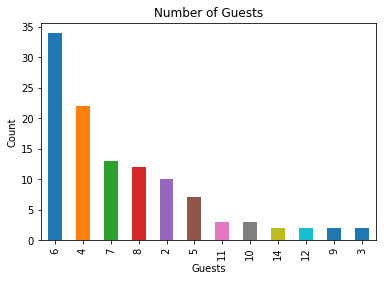

In [19]:
nsw_data['guests'].value_counts().plot(kind='bar')
plt.title('Number of Guests')
plt.xlabel('Guests')
plt.ylabel('Count')

In [20]:
nsw_data['guests'].groupby(nsw_data['guests']).count()

guests
2     10
3      2
4     22
5      7
6     34
7     13
8     12
9      2
10     3
11     3
12     2
14     2
Name: guests, dtype: int64

## Combined Data Set

Merge the 4 data files together to get the complete picture.
* nsw_data
* geodata
* cal
* book_sum

In [21]:
# Merge the nsw_extract with the geocoded data: only need the postcode, council, suburb. 
# Convert them to integer values first


full_dataset_1 = nsw_extract.merge(geodata_rev, how='left', left_index=True, right_index=True)

full_dataset_2 = full_dataset_1.merge(cal, how='left', left_index=True, right_index=True)

full_dataset_3 = full_dataset_2.merge(book_cust, how='left', left_index=True, right_index=True)

full_dataset_4 = full_dataset_3.merge(feat, how='left', left_index=True, right_index=True)


# NOTE: Dont filter on property here, keep them all until the end!!
# Join with property type, keeping property id as the index type
#full_dataset_5 = (full_dataset_4.reset_index()
#                  .merge(prop_type_table, how='left', on=['property_type'])
#                  .set_index('property_id')
#                 )

#full_dataset_5['total_booked_days'][0:5]

full_dataset_4.head()


bathrooms  bedrooms  beds  \
property_id                              
4840533              1         3     3   
4841630              1         2     2   
4845880              4         4     6   
4845880              4         4     6   
4848261              1         1     1   

                                              description_full  \
property_id                                                      
4840533      [JUST LISTED The lovely old cottage has been f...   
4841630      [This 2 bedroom unit is only 2 blocks to the C...   
4845880      [Just a few steps from the historic and beauti...   
4845880      [Just a few steps from the historic and beauti...   
4848261      [Nestled away at the end of a quiet cul-de-sac...   

             description_wc  guests  \
property_id                           
4840533                  70       6   
4841630                  57       4   
4845880                 192       8   
4845880                 192       8   
4848261                 148       2   

                                                       heading  init_price  \
property_id                                                                  
4840533                          Quiet street and close to CBD         133   
4841630                                   Perfect Parker Place         253   
4845880      Central to Orange, PLC, Duntryleague, a comfor...         290   
4845880      Central to Orange, PLC, Duntryleague, a comfor...         290   
4848261                             Beautiful Claremont Studio         135   

                   lat        lng    ...    f_communal_pool  f_hot_tub  \
property_id                          ...                                 
4840533     -33.284756  149.08614    ...                  0          0   
4841630     -33.279133  149.10138    ...                  0          0   
4845880     -33.279736  149.08318    ...                  0          0   
4845880     -33.279736  149.08318    ...                  0          0   
4848261     -33.288708  149.06300    ...                  0          0   

            f_events_allowed f_telephone  f_fitness_room_equipment  \
property_id                                                          
4840533                    0           0                         0   
4841630                    0           0                         0   
4845880                    1           0                         0   
4845880                    1           0                         0   
4848261                    0           0                         0   

             f_video_games f_indoor_pool f_heated_pool  f_private_pool  \
property_id                                                              
4840533                  0             0             0               0   
4841630                  0             0             0               0   
4845880                  0             0             0               0   
4845880                  0             0             0               0   
4848261                  0             0             0               0   

             f_tennis  
property_id            
4840533             0  
4841630             0  
4845880             0  
4845880             0  
4848261             0  

[5 rows x 82 columns]

In [22]:
# Drop some unnecessary columns
#full_dataset_5.drop(columns=['lat', 'lng','syd_brg','scraped_date','property_type','features','url','description_full','heading'],inplace=True)

# Replace any 'NaN' values with zeros
#full_dataset_4.fillna(0,inplace=True)

# Sort based on the total booked days for the current 6 month window, sort descending
#full_dataset_6 = full_dataset_5.sort_values(by=['property_id'], ascending=False)

full_dataset_5 = full_dataset_4 #.merge(page_pos, how='left', left_index=True, right_index=True)


# Replace the number of days with only the bucket. For 30 day predictions we have 7 buckets as:
# 0 - No bookins
# 1 - 1-5 days booked
# 2 - 6-10 days booked
# 3 - 11-15 days
# 4 - 16-20 days
# 5 - 21-25 days
# 6 - 26-30 days


#full_dataset_6['days_booked_bucket'] = (full_dataset_6['total_booked_days']//15)
#full_dataset_6.drop(['total_booked_days'],axis=1,inplace=True)



# Drop Property_ID and Postcode and Extracted_At date, Reviews and Review_Count are duplicates drop one
# Drop the council ID, the postcode should be enough identifier

full_dataset_6 = full_dataset_5.drop(['postcode','ext_at','reviews','council_id'],axis=1)


# Calculate the revenue
full_dataset_6['revenue'] = full_dataset_6['init_price'] * full_dataset_6['book_days']


full_dataset = full_dataset_6


In [23]:
# Write out the full dataset

csv_out = full_dataset.to_csv()

fh = open('/Users/taj/GitHub/scraping/stayz/WebData/nsw_fulldata/stayz_nsw_fulldata_' + date_str + '.csv', 'w')

fh.write(csv_out)

fh.close()

# Orange Property Analysis
The best properties across Feb to June with highest consistent revenues are:

1. *9062114* - BELL HILL, ORANGE, NSW (\$610)
1. *9132767* - A COLOURCITY APARTMENTS: COMPLEX FOR GROUPS/FAMILY ($1803)
1. *9137336* - YOURSTAY GROUP THE EDWARD TOWNHOUSES (\$350)
1. *9148674* - YOURSTAY GROUP THE DORA HALL (\$175)
1. *9161578* - YOURSTAY GROUP THE GUEST HOUSE (No price listed, calendar always unavailable)
1. *9168471* - MAGNIFICENT "WILLOWOOD," ORANGE (\$1087)
1. *9169308* - HAMER HOUSE IN CENTRAL ORANGE - ENTIRE HOUSE (\$390)
1. *9170214* - Lovely "Orangewood" Country Home - Pool & Views
1. *9175890* - "URALLA" - 5 MINS FROM ORANGE
1. *9199601* - LARGE & LUXURIOUS HERITAGE HOUSE - CENTRAL ORANGE (\$807)
1. *9202004* - "THORNLEIGH" - HOMESTEAD NEAR ORANGE NSW (\$1700)
1. *9212182* - Gunya - Huge, Unique, Home


Total number of properties: 117


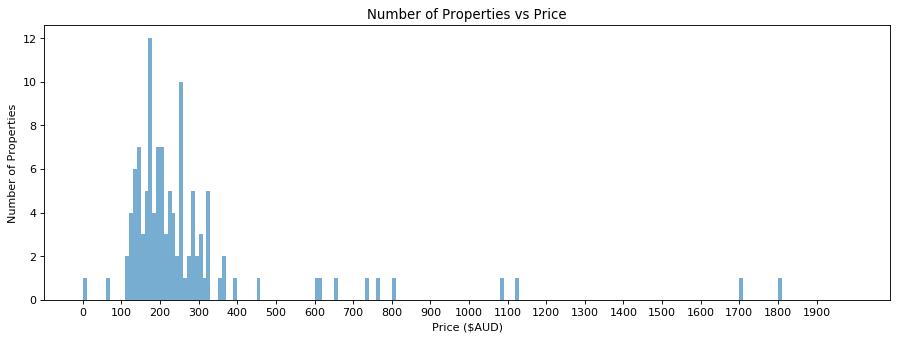

In [24]:
# Set the number of bars for the graph

n_limit = 2000

bin_values = np.arange(start=0, stop=n_limit, step=10)

# Create the figure
f1 = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
ax = f1.add_subplot(221)
ax.set(title='Number of Properties vs Price'
      ,xlabel='Price ($AUD)'
      ,ylabel='Number of Properties')


# Get the initial price

#x1 = x = full_dataset[full_dataset['suburb_id']==165]


x1 = full_dataset
#x2 = x1[x1['mth']==5]['init_price']
x2 = x1['init_price']
x2.describe()
# Remove the rows where price is empty (NaN)
#x2 = x2.dropna()

x = x2

print("Total number of properties: " + str(len(x)))

plt.xticks(np.arange(0, n_limit, 100))

# Plot a histogram of the init_price
ax.hist(x, bins=bin_values, alpha=.6) # alpha for transparency

plt.show()

In [25]:
x2.describe()

count     117.000000
mean      278.615385
std       259.644746
min         0.000000
25%       170.000000
50%       206.000000
75%       283.000000
max      1803.000000
Name: init_price, dtype: float64

/Users/taj/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


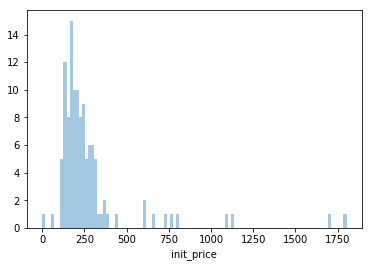

In [26]:
# Do a histgram with Seaborn to colour by suburb id

sns.distplot(full_dataset['init_price'], bins=100, kde=False, rug=False);

In [27]:
# Show the 12 Orange properties in question:
full_dataset[full_dataset['guests']>= 10]['suburb_id']


property_id
9062114     165
9132767     165
9137336     165
9148674     165
9161578     165
9168471     165
9169308     165
9170214    1207
9175890    1223
9199601     165
9202004    1064
9212182     754
Name: suburb_id, dtype: int64

In [28]:
# Check which one has a zero price
full_dataset[full_dataset['init_price'] == 0]

bathrooms  bedrooms  beds  \
property_id                              
9161578              3         4     7   

                                              description_full  \
property_id                                                      
9161578      [---ALL OUR YOURSTAY GROUP PROPERTIES CAN BE B...   

             description_wc  guests                         heading  \
property_id                                                           
9161578                 195      12  Yourstay Group The Guest House   

             init_price        lat        lng   ...    f_hot_tub  \
property_id                                     ...                
9161578               0 -33.291138  149.11101   ...            0   

            f_events_allowed f_telephone  f_fitness_room_equipment  \
property_id                                                          
9161578                    0           0                         0   

             f_video_games f_indoor_pool  f_heated_pool f_private_pool  \
property_id                                                              
9161578                  0             1              0              0   

             f_tennis  revenue  
property_id                     
9161578             0      0.0  

[1 rows x 79 columns]

In [29]:
# Find which suburb is Orange
#org = suburb_1[suburb_1['suburb'] == 'Mudgee']

# Suburb ID's
# Orange = 165
# Mudgee = 41
# Buckaroo = 683

# Forest Reefs = 1207
# Spring Creek = 1223
# Borenore = 1064
# Lidster = 754


p1 = suburb_1.loc[754]
p1

#suburb_1.head(100)

suburb       Lidster
suburb_id        754
Name: 754, dtype: object

In [30]:
# Find all houses of 10 guests or more in orange

o10_1 = full_dataset.fillna(0)

o10_2 = o10_1[o10_1['guests'] >= 10]

o10_3 = o10_2.merge(geodata, how='left', left_index=True, right_index=True)

o10_4 = o10_3[['heading','suburb','bathrooms','bedrooms','guests','init_price','mth','book_days','revenue']]




o10_4.sort_values(by=['mth','revenue'],ascending=False)

heading        suburb  \
property_id                                                                    
9168471                        Magnificent "Willowood," Orange        Orange   
9199601      Large & luxurious heritage house - Central Orange        Orange   
9175890                          "Uralla" - 5 mins from Orange  Spring Creek   
9170214        Lovely "Orangewood" Country Home - Pool & Views  Forest Reefs   
9137336                   Yourstay Group The Edward Townhouses        Orange   
9169308           Hamer House in Central Orange - Entire House        Orange   
9161578                         Yourstay Group The Guest House        Orange   
9062114                                 BELL HILL, Orange, NSW        Orange   
9132767      A Colourcity Apartments: Complex for groups/fa...        Orange   
9148674                           Yourstay Group The Dora Hall        Orange   
9202004               "Thornleigh" - Homestead near Orange NSW      Borenore   
9212182                             Gunya - Huge, Unique, Home       Lidster   

             bathrooms  bedrooms  guests  init_price  mth  book_days  revenue  
property_id                                                                    
9168471              4         6      12        1087  5.0        4.0   4348.0  
9199601              4         6      12         807  5.0        3.0   2421.0  
9175890              4         7      14        1126  5.0        2.0   2252.0  
9170214              2         5      11         730  5.0        3.0   2190.0  
9137336              2         6      14         350  5.0        6.0   2100.0  
9169308              2         4      10         390  5.0        3.0   1170.0  
9161578              3         4      12           0  5.0       12.0      0.0  
9062114              2         4      11         610  0.0        0.0      0.0  
9132767              8        10      16        1803  0.0        0.0      0.0  
9148674              1         4      10         175  0.0        0.0      0.0  
9202004              4         5      10        1700  0.0        0.0      0.0  
9212182              3         4      11         766  0.0        0.0      0.0

Total number of properties: 117
[45 14 13 14 11  9  5  3  0  0  1  0  2  0  0]


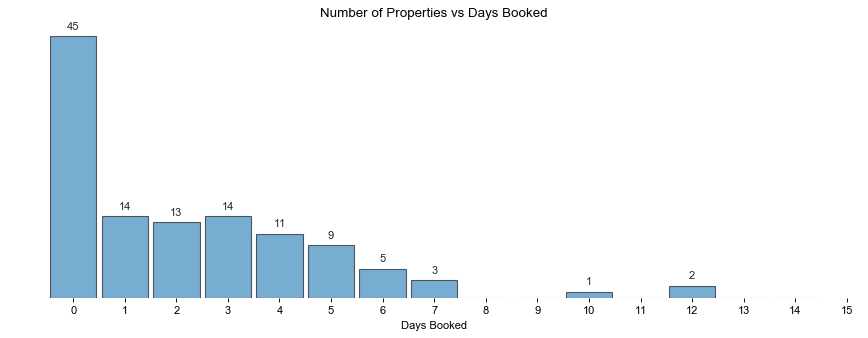

In [31]:
# Histogram of how many properties get bookings



# Set the number of bars for the graph
bin_values = np.arange(start=0, stop=16, step=1)

# Create the figure
f1 = plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
ax = f1.add_subplot(221)

rects = ax.patches



#plt.yticks(np.arange(min(x), max(x)+1, 1.0))

plt.style.use('seaborn-white')

ax.set(title='Number of Properties vs Days Booked'
      ,xlabel='Days Booked'
      ,ylabel='Number of Properties')

ax.patch.set_facecolor('#FFFFFF')

ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(False)

# Get the initial price
a1 = full_dataset #[full_dataset['mth'] == 5]

#a2 = a1[a1['suburb_id'].isin([165])]['book_days']

a2 = a1['book_days']

a3 = a2.fillna(0)

x = a3

plt.xticks(np.arange(min(x), 16, 1))

#x2 = full_dataset[full_dataset['guests'] > 8]


# Remove the rows where price is empty (NaN)
#x = x.dropna()

ax.hist(x, bins=bin_values-0.5, alpha=.6, edgecolor='black', rwidth=0.9) # alpha for transparency


print("Total number of properties: " + str(len(x)))


counts, bin_edges = np.histogram(x, bins=bin_values)


print(counts)


# Label the raw counts and the percentages below the x-axis...
bin_centers = 0.5 * np.diff(bin_values) + bin_values[:-1]

# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5
    # Vertical alignment for positive values
    va = 'bottom'

    # If value of bar is negative: Place label below bar
    if y_value < 0:
        # Invert space to place label below
        space *= -1
        # Vertically align label at top
        va = 'top'

    # Use Y value as label and format number with one decimal place
    label = "{:d}".format(int(y_value))

    # Create annotation
    if( y_value > 0 ):
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            #color='black',
            #size=14,
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.
# Plot a histogram of the init_price
#x.plot(kind='bar', alpha=.6) # alpha for transparency


plt.show()

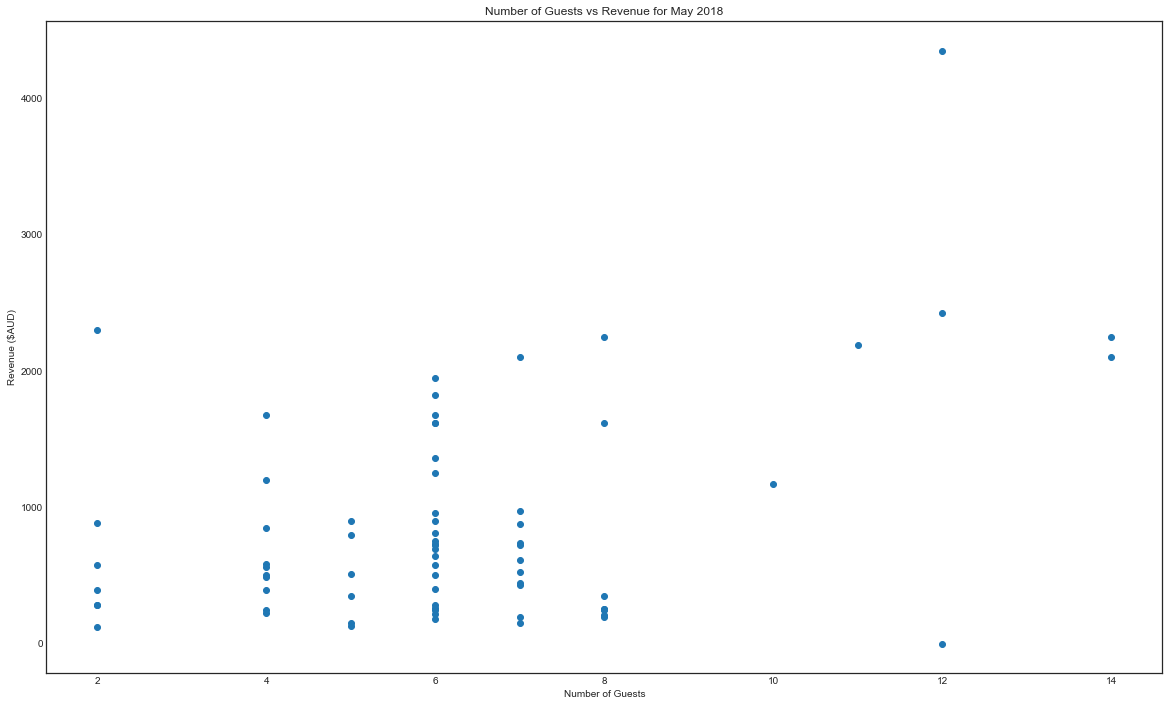

In [82]:
# Plot the bookings vs the initial price

#plot_ds = full_dataset[full_dataset['total_booked_days'] > 0]

# Plot the Orange suburb
plot_ds_2 = full_dataset #[full_dataset['suburb_id'].isin([683,41])]

plot_ds_3 = plot_ds_2 #[plot_ds_2['mth'] == 4]

plot_ds_3['revenue'] = plot_ds_3['init_price'] * plot_ds_3['book_days']


#plot_ds_3.info()

plt.figure(figsize=(20,12))

plt.title('Number of Guests vs Revenue for May 2018')
plt.xlabel('Number of Guests')
plt.ylabel('Revenue ($AUD)')
plt.scatter(plot_ds_3['guests'],plot_ds_3['revenue'])

plt.show()

In [78]:
# Get the top 10 by revenue
rev10 = full_dataset #[full_dataset['suburb_id'].isin([165])]

rev10a = rev10.sort_values(by=['revenue'],ascending=False)

rev10a.head(5)


bathrooms  bedrooms  beds  \
property_id                              
9168471              4         6    10   
9199601              4         6     7   
9203097              1         1     1   
9175890              4         7     7   
9155220              2         4     5   

                                              description_full  \
property_id                                                      
9168471      [This outstanding home boasts 4 double bedroom...   
9199601      [Newly renovated, this stunning central double...   
9203097      [THE VINES STUDIO , Accommodation for 1 couple...   
9175890      ["Uralla" is a substantial, modern and comfort...   
9155220      [Modern & Spacious - plenty of sofa spaces to ...   

             description_wc  guests  \
property_id                           
9168471                 318      12   
9199601                 257      12   
9203097                 122       2   
9175890                 215      14   
9155220                 416       8   

                                                       heading  init_price  \
property_id                                                                  
9168471                        Magnificent "Willowood," Orange        1087   
9199601      Large & luxurious heritage house - Central Orange         807   
9203097             Mortimers Wines - Studio amongst the Vines         230   
9175890                          "Uralla" - 5 mins from Orange        1126   
9155220                             Getaway On Poplars, Orange         450   

                   lat        lng   ...    f_hot_tub f_events_allowed  \
property_id                         ...                                 
9168471     -33.300297  149.14983   ...            0                0   
9199601     -33.293007  149.10464   ...            0                0   
9203097     -33.223557  149.08980   ...            0                1   
9175890     -33.340435  149.08280   ...            0                0   
9155220     -33.275852  149.06621   ...            0                0   

            f_telephone  f_fitness_room_equipment  f_video_games  \
property_id                                                        
9168471               0                         0              0   
9199601               0                         0              0   
9203097               0                         0              0   
9175890               0                         0              0   
9155220               0                         0              0   

            f_indoor_pool  f_heated_pool f_private_pool  f_tennis  revenue  
property_id                                                                 
9168471                 0              0              1         1   4348.0  
9199601                 0              0              0         0   2421.0  
9203097                 0              0              0         0   2300.0  
9175890                 0              0              1         0   2252.0  
9155220                 0              0              0         0   2250.0  

[5 rows x 79 columns]

Text(-1.45,0.5,'Revenue ($)')

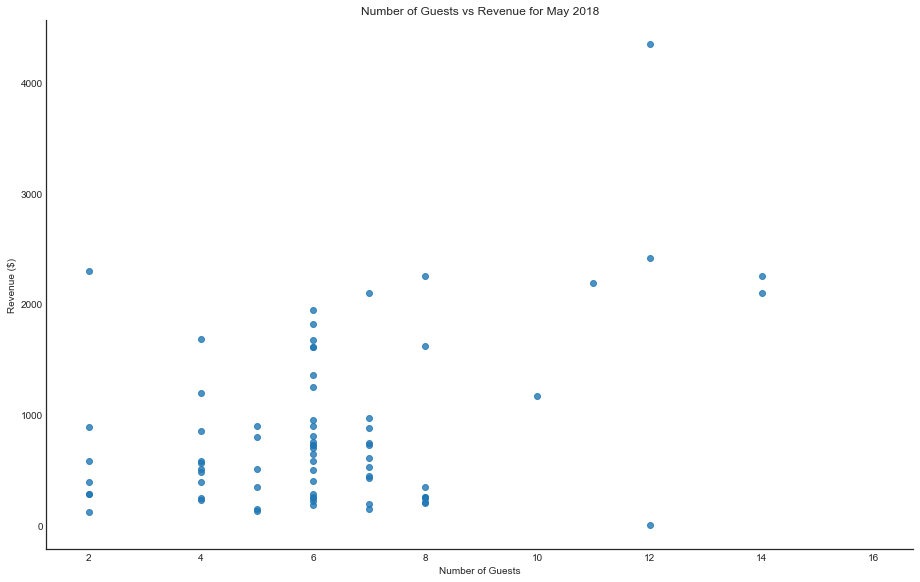

In [81]:
# Now check individual graphs in detail
ax = sns.lmplot( x="guests", y="revenue", data=rev10a, fit_reg=False
#           , hue='suburb_id'
           , aspect=1.61
          , size=8)

ax = plt.gca()
ax.set_title("Number of Guests vs Revenue for May 2018")
ax.set_xlabel("Number of Guests")
ax.set_ylabel("Revenue ($)")

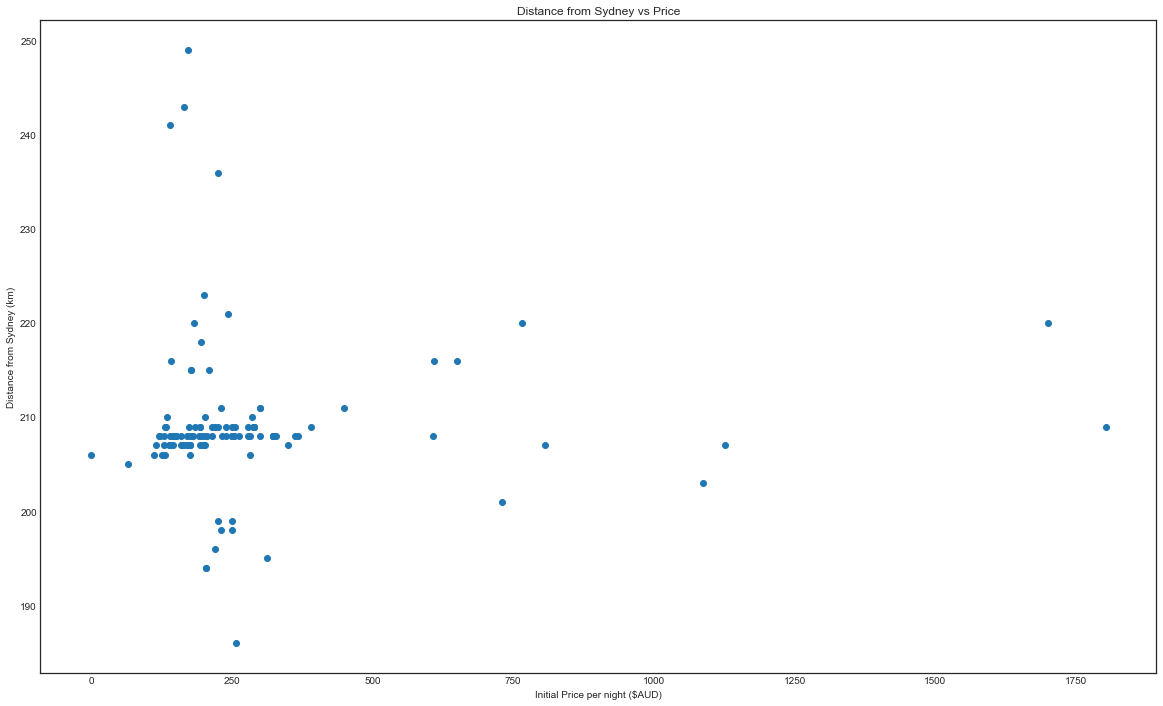

In [35]:
# Now draw a graph of Initial Price vs Distance from Sydney
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,12))


#nsw_data_s6 = nsw_data_s5[nsw_data_s5['syd_dist_km'] <= 250]

#nsw_data_s7 = nsw_data_s6[nsw_data_s6['init_price'] <= 600]

plt.title('Distance from Sydney vs Price')
plt.xlabel('Initial Price per night ($AUD)')
plt.ylabel('Distance from Sydney (km)')
plt.scatter(full_dataset['init_price'],full_dataset['syd_dist_km'])

plt.show()

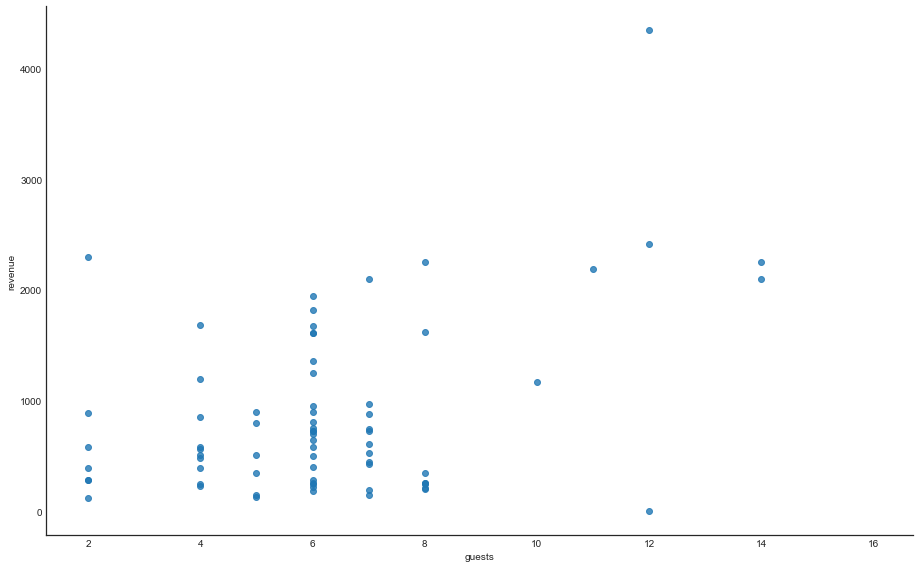

In [36]:
# Now check individual graphs in detail
sns.lmplot( x="guests", y="revenue", data=plot_ds_2, fit_reg=False
           #, hue='prop_type_id'
           , aspect=1.61
          , size=8)


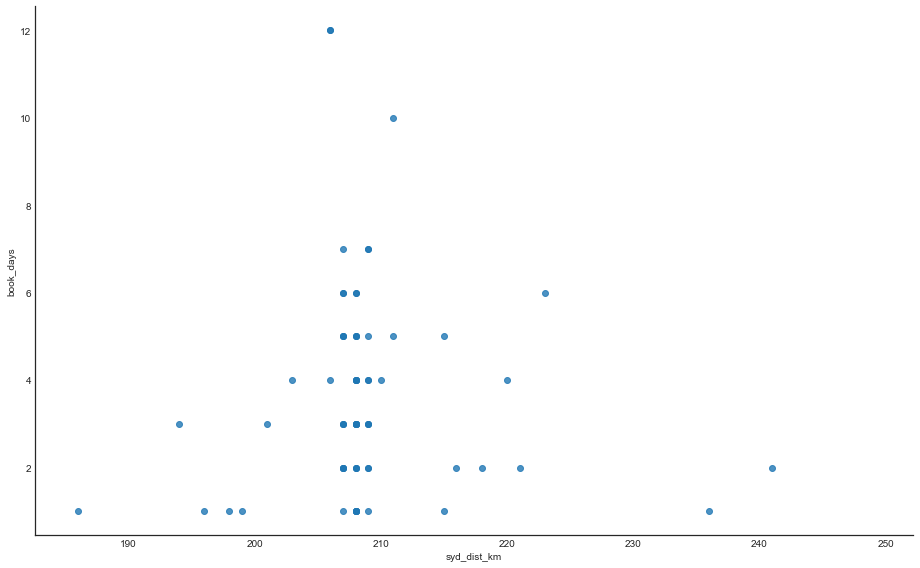

In [39]:
# Now check individual graphs in detail

# Try just one property_type - House

nsw_data_s8 = plot_ds_2#[plot_ds_2['prop_type_id'] == 1]

sns.lmplot( x="syd_dist_km", y="book_days", data=nsw_data_s8, fit_reg=False
#           , hue='prop_type_id'
           , aspect=1.61
          , size=8)

In [ ]:
#test_cor = full_dataset.corr(method='pearson')

#test_cor

In [ ]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
#plot_corr(full_dataset)

# Generate the QGIS data file from the full_dataset


In [77]:
#date_str = datetime.datetime.now().strftime("%Y-%m-%d")

csv_file = open('/Users/taj/GitHub/scraping/stayz_analysis/WebData/stayz_nsw_extract_' + date_str + '.csv', 'w')

csvw = csv.writer(csv_file
                 ,delimiter=','
                 ,quotechar='"'
                 ,quoting=csv.QUOTE_MINIMAL)

csvw.writerow(["property_id", "lat", "lng", "guests", "init_price","revenue"])

csvdata = full_dataset.fillna(0).reset_index()

for index, row in csvdata.iterrows():
    csvw.writerow(row[['property_id','lat','lng','guests','init_price','revenue']])
